In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TABLEAU_COLORS, CSS4_COLORS
from tqdm.auto import tqdm
import seaborn as sns
import math
import pickle
from scipy.signal import find_peaks, savgol_filter
from scipy.stats import mode, permutation_test, pearsonr
from scipy.spatial import distance
from scipy import interpolate
from pathlib import Path
import functools
import cv2
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['axes.grid'] = False
import os
if Path('.').resolve().name != 'Arena':
    os.chdir('../Arena')
from db_models import ORM, Experiment, Strike, Block, Video, Trial
from analysis.pose_utils import plot_regression, colorline, pixels2cm, fit_circle
from analysis.pose import DLCArenaPose, SpatialAnalyzer
from analysis.predictors.tongue_out import TongueOutAnalyzer, TONGUE_CLASS
from analysis.strikes.strikes import Loader, StrikeAnalyzer

In [2]:
orm = ORM()
FIGURE_PATH = '../notebooks/figures'
BAD_ANIMALS = ['PV03', 'PV26', 'PV72', 'PV87', 'PV88', 'PV90', 'PV101', 'PV119', 'PV144']
SCREEN_Y_POS = {'reptilearn4': -3, 'msi-regev': 0.06}

In [11]:
with orm.session() as s:
    orm_res = s.query(Trial, Block, Experiment).join(
      Block, Block.id == Trial.block_id).join(
      Experiment, Experiment.id == Block.experiment_id).filter(
        Experiment.arena == 'reptilearn4',
        Experiment.start_time > '2023-06-01',
        Block.movement_type == 'jump_up'
    ).all()
    
    res = {}
    for tr, _, _ in tqdm(orm_res):
      if len(tr.strikes) < 2:
        continue
      res[tr.id] = []
      for strk in tr.strikes:
        try:
          ld = Loader(int(strk.id), 'front', sec_before=0.5, sec_after=0.5)
          traj_df = ld.get_bug_traj_around_strike()
          pose_df = ld.get_bodypart_pose('nose')
          df = pd.merge_asof(left=pose_df, right=traj_df, left_on='time', right_on='time', 
                             direction='nearest', tolerance=pd.Timedelta('100 ms'), suffixes=('_pose', '_traj'))
          # df['time'] = (df.time - pose_df.loc[ld.strike_frame_id].time).dt.total_seconds()
          res[tr.id].append((df.time.values, df.y_pose.values, df.y_traj.values))
        except Exception as exc:
          print(f'{strk.id} - {exc}')
                
res = {k: v for k, v in res.items() if v}

  0%|          | 0/1494 [00:00<?, ?it/s]

1234 - traj_df is empty
1235 - traj_df is empty
1231 - traj_df is empty
1233 - traj_df is empty
1230 - traj_df is empty
1232 - traj_df is empty
1005 - traj_df is empty
1007 - traj_df is empty
1006 - traj_df is empty
1042 - frames_df is empty after loading
1051 - traj_df is empty
1052 - traj_df is empty
1068 - traj_df is empty
1069 - traj_df is empty
1071 - traj_df is empty
1072 - traj_df is empty
1073 - traj_df is empty
1074 - traj_df is empty
1070 - traj_df is empty
2840 - Video prediction was not found for video db id: 3343
2838 - Video prediction was not found for video db id: 3343
2839 - Video prediction was not found for video db id: 3343
2836 - Video prediction was not found for video db id: 3343
2837 - Video prediction was not found for video db id: 3343
2846 - Video prediction was not found for video db id: 3347
2847 - Video prediction was not found for video db id: 3347
2848 - Video prediction was not found for video db id: 3347
2849 - Video prediction was not found for video 

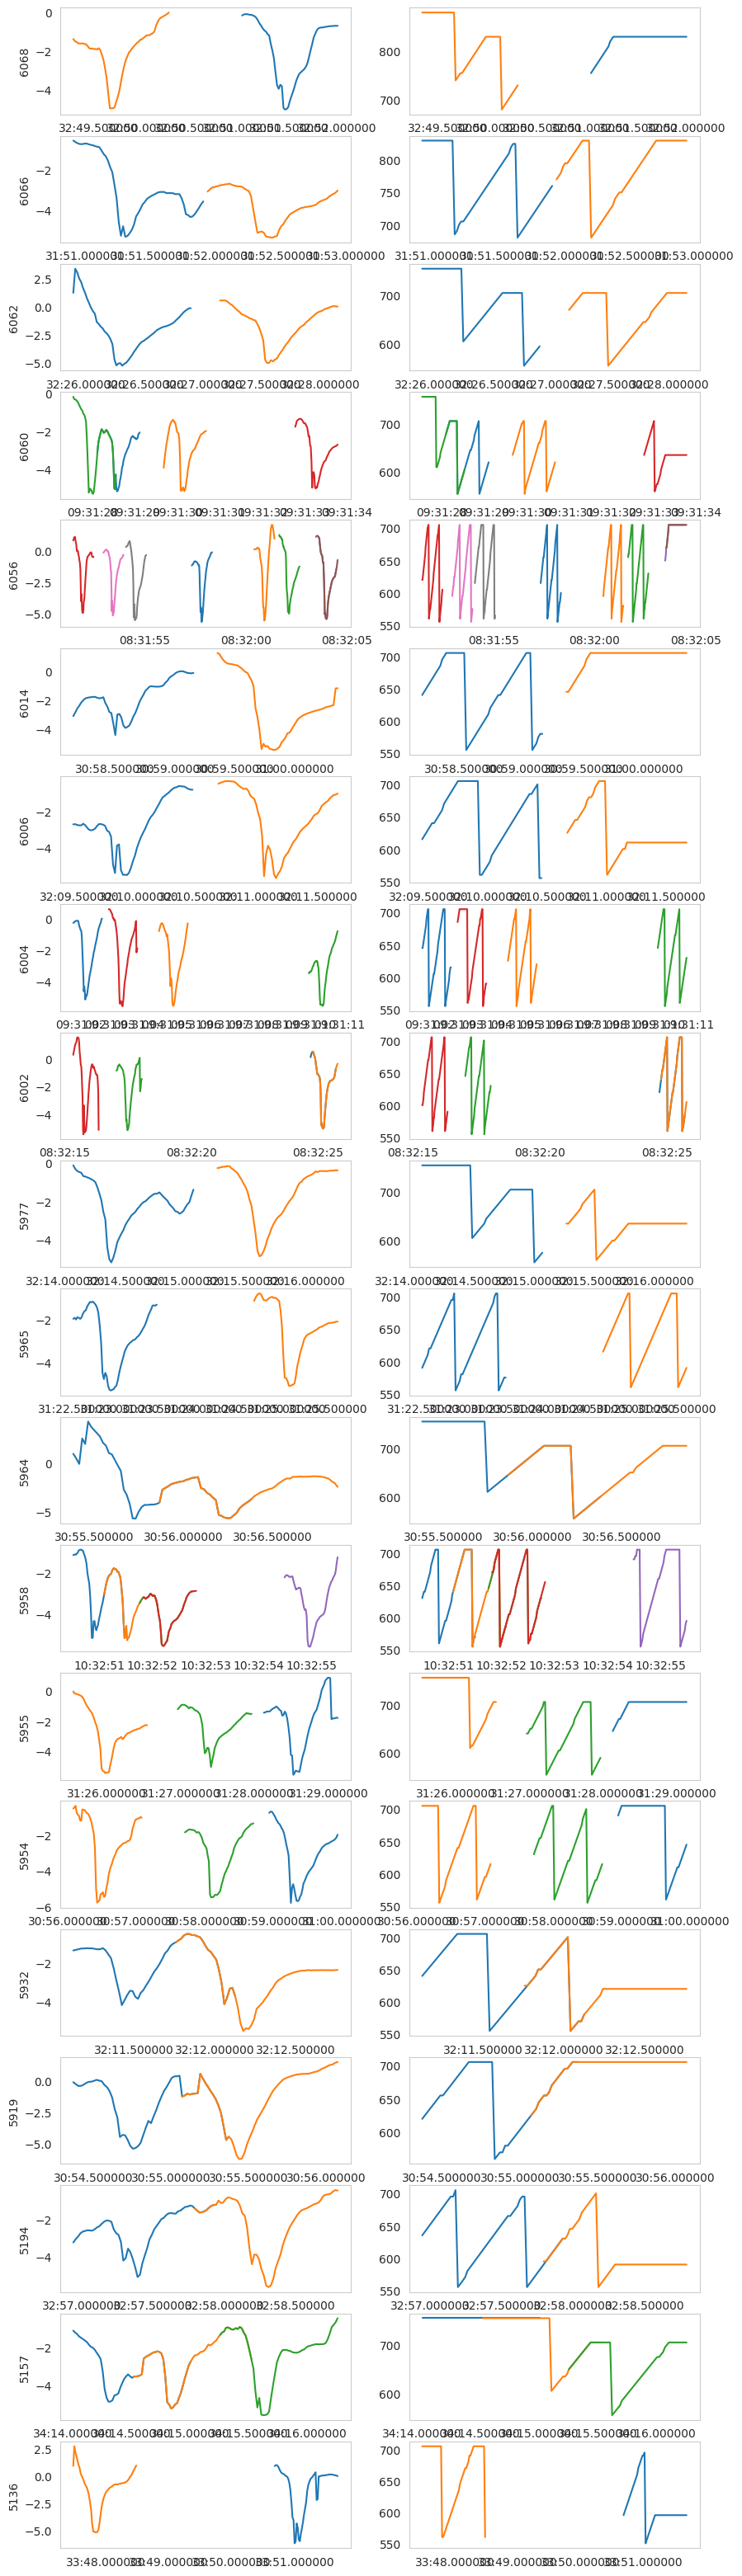

In [12]:
n = 20
fig, axes = plt.subplots(n, 2, figsize=(10, n*2))
i = 0
for trial_id in list(res.keys())[::-1]:
  res_ = res[trial_id]
  if i >= n:
    continue
  axes[i, 0].set_ylabel(str(trial_id))
  for r in res_:
    axes[i, 0].plot(r[0], r[1])
    axes[i, 1].plot(r[0], r[2])
  i += 1

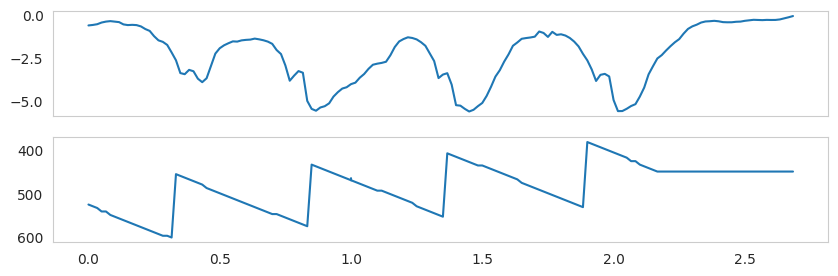

In [88]:
res_ = res[13927]
fig, axes = plt.subplots(2, 1, figsize=(10, 3))
t = np.concatenate([r[0] for r in res_])
tidx = t.argsort()
t = t[tidx]
t = pd.Series(t - t[0]).dt.total_seconds().values
axes[0].plot(t, np.concatenate([r[1] for r in res_])[tidx])
axes[0].set_xticks([])
axes[1].plot(t, np.concatenate([r[2] for r in res_])[tidx])
axes[1].invert_yaxis()

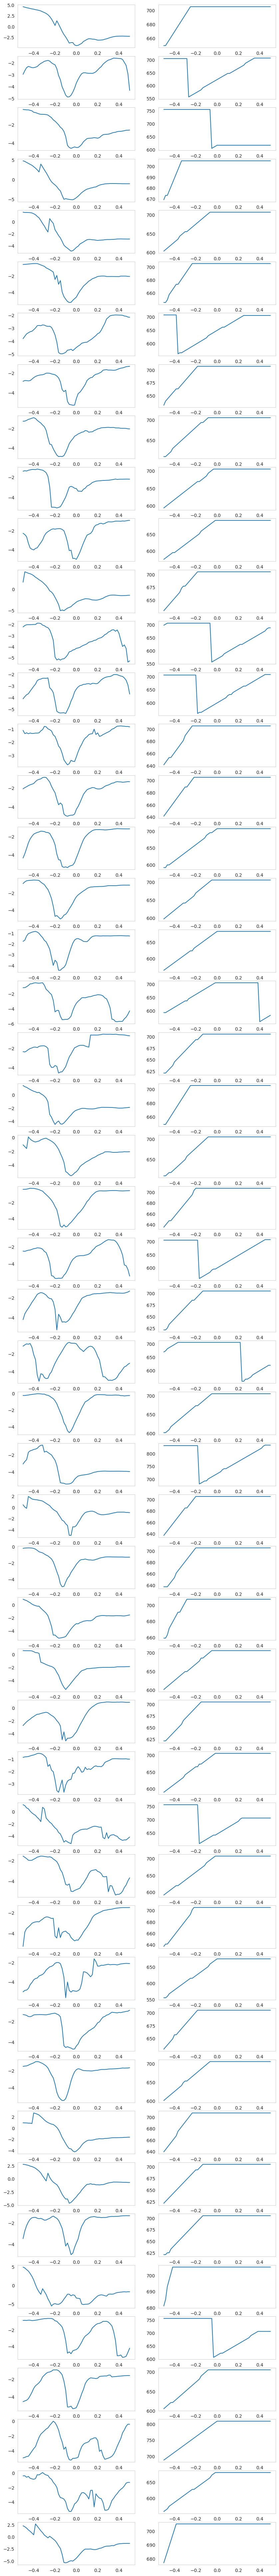

In [46]:
n = 50
fig, axes = plt.subplots(n, 2, figsize=(10, n*2))
i = 0
for r in res:
  if i >= n:
    break
  if (r[2] < 700).any():
    axes[i, 0].plot(r[0], r[1])
    axes[i, 1].plot(r[0], r[2])
    i += 1

(0.0, 20.0)

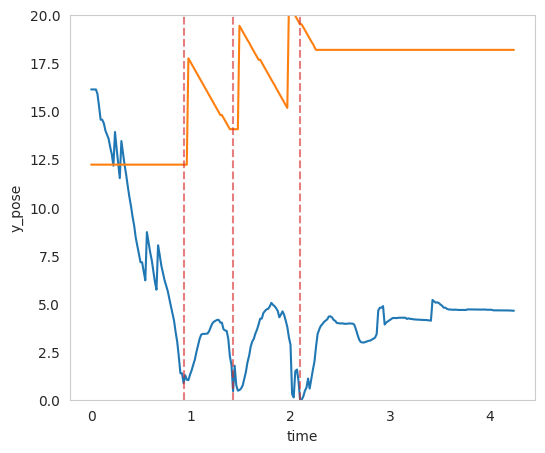

In [148]:
trial_id = 13720
with orm.session() as s:
    orm_res = s.query(Trial, Block).join(Block, Block.id == Trial.block_id).filter(Trial.id==trial_id).first()
    traj = pd.DataFrame(orm_res[0].bug_trajectory)
    traj['time'] = pd.to_datetime(traj.time).dt.tz_localize(None)
    vid = [vid for vid in orm_res[1].videos if vid.cam_name=='front'][0]
    pose = DLCArenaPose(cam_name='front').load(video_db_id=int(vid.id))
    pose['time'] = pd.to_datetime(pose.time, unit='s')
    pose = pd.concat([pose['time'], pose['nose']], axis=1)
    
    df = pd.merge_asof(left=traj, right=pose, left_on='time', right_on='time', 
                       direction='nearest', tolerance=pd.Timedelta('100 ms'), suffixes=('_traj', '_pose'))
    
df['time'] = (df.time - df.time.iloc[0]).dt.total_seconds()
df['y_traj'] = -(df.y_traj * (53/1440)) + 40
df['y_pose'] = df.y_pose - df.y_pose.min()

fig, ax = plt.subplots(1, 1, figsize=(6, 5))
sns.lineplot(data=df, x='time', y='y_pose', ax=ax)
sns.lineplot(data=df, x='time', y='y_traj', ax=ax)
peaks, _ = find_peaks(-df.y_pose, height=-2, distance=20, width=8)
for t_ in df.time.iloc[peaks].values:
  plt.axvline(t_, linestyle='--', c='tab:red', alpha=0.6)
ax.set_ylim([0, 20])

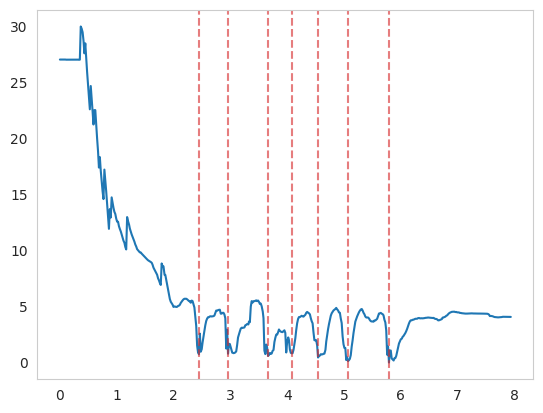

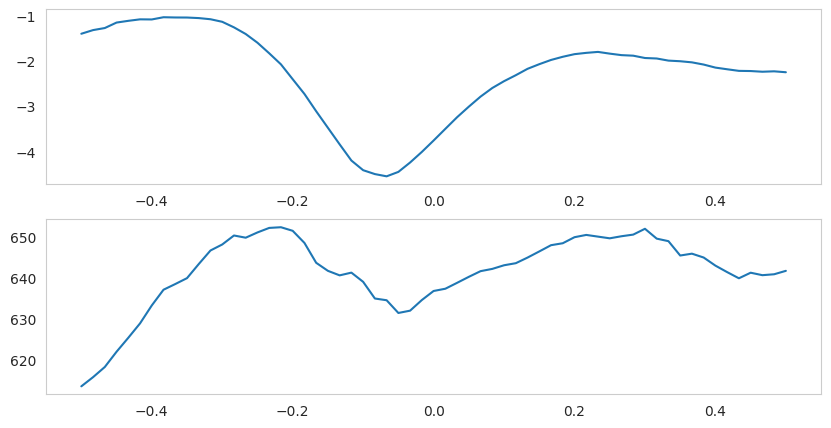

In [44]:
idx = [i for i, r in enumerate(res) if (r[2] < 700).any()]

pose_y = np.nanmean(np.vstack([x[1] for x in np.array(res)[idx]]), axis=0)
traj_y = np.nanmean(np.vstack([x[2] for x in np.array(res)[idx]]), axis=0)
fig, axes = plt.subplots(2, 1, figsize=(10, 5))
axes[0].plot(res[0][0], pose_y)
axes[1].plot(res[0][0], traj_y)

In [13]:
df = pd.merge_asof(left=pose_df, right=traj_df, left_on='time', right_on='time', 
                   direction='nearest', tolerance=pd.Timedelta('100 ms'), suffixes=('_pose', '_traj'))
df

,time,cam_x,cam_y,prob,x_pose,y_pose,x_traj,y_traj
0,2023-05-31 09:36:56.289805824,881.322327,713.982605,0.999980,12.891213,5.116192,1639,755
1,2023-05-31 09:36:56.306471936,881.275452,713.964050,0.999980,12.893800,5.117261,1639,755
2,2023-05-31 09:36:56.323139072,881.338379,713.873901,0.999980,12.890327,5.122453,1635,755
3,2023-05-31 09:36:56.339804928,881.237244,713.778809,0.999978,12.895909,5.127930,1631,755
4,2023-05-31 09:36:56.356472064,881.165100,713.767151,0.999977,12.899891,5.128601,1627,755
...,...,...,...,...,...,...,...,...
236,2023-05-31 09:37:00.223077888,504.704010,904.293640,0.999876,21.735356,-0.189697,1267,705
237,2023-05-31 09:37:00.239744000,504.537811,903.236938,0.999925,21.745105,-0.128837,1267,705
238,2023-05-31 09:37:00.256411136,504.421417,902.344360,0.999951,21.751933,-0.077429,1267,705
239,2023-05-31 09:37:00.273076992,504.478088,901.922485,0.999956,21.748608,-0.053131,1267,705


In [20]:
df['time2'] = (df.time - pose_df.loc[ld.strike_frame_id].time).dt.total_seconds()
df

,time,cam_x,cam_y,prob,x_pose,y_pose,x_traj,y_traj,time2
0,2023-05-31 09:36:56.289805824,881.322327,713.982605,0.999980,12.891213,5.116192,1639,755,-1.999968
1,2023-05-31 09:36:56.306471936,881.275452,713.964050,0.999980,12.893800,5.117261,1639,755,-1.983302
2,2023-05-31 09:36:56.323139072,881.338379,713.873901,0.999980,12.890327,5.122453,1635,755,-1.966635
3,2023-05-31 09:36:56.339804928,881.237244,713.778809,0.999978,12.895909,5.127930,1631,755,-1.949969
4,2023-05-31 09:36:56.356472064,881.165100,713.767151,0.999977,12.899891,5.128601,1627,755,-1.933302
...,...,...,...,...,...,...,...,...,...
236,2023-05-31 09:37:00.223077888,504.704010,904.293640,0.999876,21.735356,-0.189697,1267,705,1.933304
237,2023-05-31 09:37:00.239744000,504.537811,903.236938,0.999925,21.745105,-0.128837,1267,705,1.949970
238,2023-05-31 09:37:00.256411136,504.421417,902.344360,0.999951,21.751933,-0.077429,1267,705,1.966637
239,2023-05-31 09:37:00.273076992,504.478088,901.922485,0.999956,21.748608,-0.053131,1267,705,1.983303


<AxesSubplot:xlabel='time', ylabel='y_traj'>

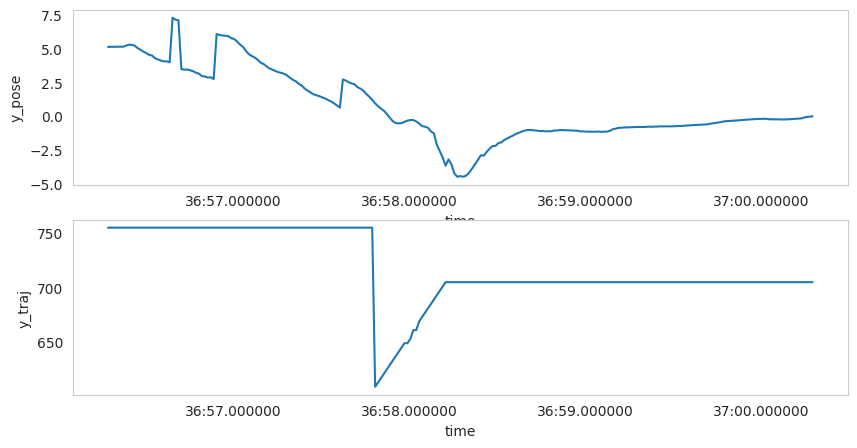

In [14]:
fig, axes = plt.subplots(2, 1, figsize=(10, 5))
sns.lineplot(data=df, x='time', y='y_pose', ax=axes[0])
sns.lineplot(data=df, x='time', y='y_traj', ax=axes[1])